In [1]:
# Import required libraries
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
# Load Chinese names corpus
words = open('Chinese_Names_Corpus.txt', 'r', encoding='utf-8-sig').read().splitlines()
print(words[:8])
len(words)

['阿安', '阿彬', '阿斌', '阿滨', '阿冰', '阿冰冰', '阿兵', '阿婵']


1144629

In [5]:
# Build vocabulary of Chinese characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)
print(list(itos.items())[:20])
print(f"Vocabulary size: {vocab_size}")

[(1, '一'), (2, '丁'), (3, '七'), (4, '万'), (5, '三'), (6, '上'), (7, '不'), (8, '与'), (9, '专'), (10, '丕'), (11, '世'), (12, '丘'), (13, '丙'), (14, '业'), (15, '丛'), (16, '东'), (17, '丝'), (18, '丞'), (19, '严'), (20, '丫')]
Vocabulary size: 2271


In [6]:
# Build the dataset
block_size = 3 # Chinese names are typically 2-4 characters

def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [7]:
# Data splitting
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([3520556, 3]) torch.Size([3520556])
torch.Size([439716, 3]) torch.Size([439716])
torch.Size([440089, 3]) torch.Size([440089])


In [8]:
# Neural network parameter
g = torch.Generator().manual_seed(2147483647) # for reproducibility
embed_dim = 64  # Increased embedding dimension for Chinese
hidden_dim = 512  # Larger hidden layer for character complexity
C = torch.randn((vocab_size, embed_dim), generator=g)
W1 = torch.randn((block_size * embed_dim, hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

1409183


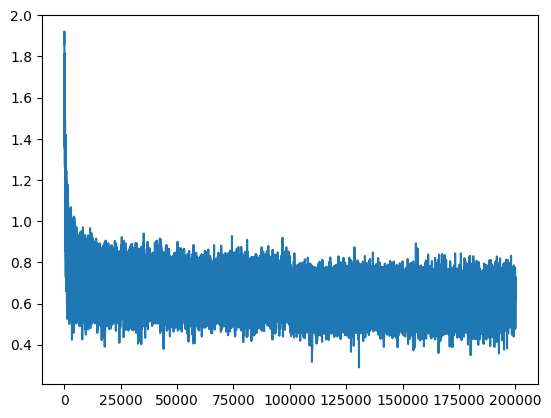

In [9]:
# Training loop
lossi = []
stepi = []
lri = []

for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, block_size*embed_dim) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())

plt.plot(stepi, lossi)

In [10]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

苑湘华.
龙杏江.
林富丽.
嘎志龙.
裴万.
刘悦成.
王求琼.
索铁葵.
肖克涛.
陈丽艳.
沈少博.
李彦.
张子.
甄大会.
张坚军.
张大婷.
王雪友.
杨笙德.
李林言.
于国彬.


In [16]:
# Model Evaluation
def evaluate_model(X, Y, parameters, batch_size=1024):
    C, W1, b1, W2, b2 = parameters

    # Initialize metrics
    total_loss = 0.0
    total_samples = X.shape[0]

    # Disable gradient computation to save memory
    with torch.no_grad():
        # Process in batches
        for start in range(0, total_samples, batch_size):
            end = min(start + batch_size, total_samples)
            batch_X = X[start:end]
            batch_Y = Y[start:end]

            # Embedding and forward pass
            emb = C[batch_X]
            h = torch.tanh(emb.view(-1, block_size*embed_dim) @ W1 + b1)
            logits = h @ W2 + b2

            # Compute loss for this batch
            batch_loss = F.cross_entropy(logits, batch_Y)
            total_loss += batch_loss.item() * (end - start)

    # Compute average metrics
    avg_loss = total_loss / total_samples

    # Perplexity calculation
    perplexity = np.exp(avg_loss)

    return {
        'loss': avg_loss,
        'perplexity': perplexity
    }


def comprehensive_model_assessment(Xtr, Ytr, Xdev, Ydev, Xte, Yte, parameters, itos):
    print("Training Set Metrics:")
    train_metrics = evaluate_model(Xtr, Ytr, parameters)
    print(train_metrics)

    print("\nValidation Set Metrics:")
    dev_metrics = evaluate_model(Xdev, Ydev, parameters)
    print(dev_metrics)

    print("\nTest Set Metrics:")
    test_metrics = evaluate_model(Xte, Yte, parameters)
    print(test_metrics)

comprehensive_model_assessment(Xtr, Ytr, Xdev, Ydev, Xte, Yte, parameters, itos)

Training Set Metrics:
{'loss': 4.327710567190905, 'perplexity': 75.77061610713723, 'top_3_accuracy': 0.3115473805843386}

Validation Set Metrics:
{'loss': 4.333056545700879, 'perplexity': 76.17676886719438, 'top_3_accuracy': 0.3123493345669711}

Test Set Metrics:
{'loss': 4.328997967381552, 'perplexity': 75.86822603079463, 'top_3_accuracy': 0.31158470215889716}
